In [1]:
import numpy as np
import pandas as pd
import os.path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

%matplotlib inline



/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Gathering

Reading NYC Restaurant Inspection data into DataFrame to grab restaurant title/address to generate appropriate yelp urls for futures scraping

In [2]:
nyccsv = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/DOHMH_New_York_City_Restaurant_Inspection_Results.csv'

df = pd.read_csv(nyccsv)

cols = ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE_DESC',
           'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE', 'VIOLATION_DESC', 'CRITICAL_FLAG',
           'SCORE', 'GRADE', 'GRADE_DATE', 'RECORD_DATE', 'INSPECTION_TYPE']
df.columns = cols




Yelp URLs are formulaic, by title and address. Generate Yelp URLs for scraping with scrapy.

In [3]:
df['ADDRESS'] = df.BUILDING + " " + df.STREET + " " + df.BORO

def yelp_url_gen(row):
    # yelp_url_gen:
    #     Yelp search urls are formulatic based upon "Find" and "Location" inserted values -
    #   so, I can generate what the urls would be if I serached by restaurant title and
    #   restaurant address

    title1 = row['DBA'].replace(" ", "+")
    address1 = row['ADDRESS'].replace(" ", "+")
    return "https://www.yelp.com/search?find_desc={title1}&find_loc={address1}".format(title1=title1, address1=address1)

df_clean = df.dropna(axis=0, how='any')
df_clean['URL'] = df_clean.apply(yelp_url_gen, axis = 1)

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Export to csv for access by scrapy program yelp_ratings.py

In [4]:
path = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/df_clean.csv'
df_clean.to_csv(path)

urllist=list(df_clean['URL'])

In [5]:
df_clean.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESC', 'INSPECTION_DATE', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESC', 'CRITICAL_FLAG', 'SCORE', 'GRADE', 'GRADE_DATE',
       'RECORD_DATE', 'INSPECTION_TYPE', 'ADDRESS', 'URL'],
      dtype='object')

# Data Exploration 1

Testing and cleaning code

df_stats = creating a smaller DataFrame to run regressions/plot

In [6]:
df_stats = df_clean.drop(['CAMIS', 
                          'PHONE',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE', 
                          'ACTION', 
                          'VIOLATION_CODE', 
                          'VIOLATION_DESC', 
                          'INSPECTION_TYPE', 
                          'URL'
                         ], 1)


Prep variables and defining functions to create Dummy Variables 'GRADE_NUM' and 'CRIT_FLAG_NUM'

In [7]:
df_stats = df_stats[df_stats.GRADE != 'Z']
df_stats = df_stats[df_stats.GRADE != 'P']
df_stats = df_stats[df_stats.GRADE != 'Not Yet Graded']

In [8]:
def grader(row):
    grade = row['GRADE']
    if grade=='A':
        return 0
    elif grade=='B':
        return 5
    elif grade=='C':
        return 10
    
df_stats['GRADE_NUM'] = df_stats.apply(grader, axis=1)

In [9]:
def criticalflag(row):
    flag = row['CRITICAL_FLAG']
    if flag == 'Critical':
        return 1
    elif flag == 'Not Critical':
        return 0

df_stats['CRIT_FLAG_NUM'] = df_stats.apply(criticalflag, axis=1)

Drop remaining unneeded columns

In [10]:
df_stats1=df_stats.drop(['DBA',
                        'CUISINE_DESC',
                        'INSPECTION_DATE',
                        'CRITICAL_FLAG',
                        'GRADE',
                        'GRADE_DATE',
                        'RECORD_DATE',
                        'ADDRESS',
                       ], 1)

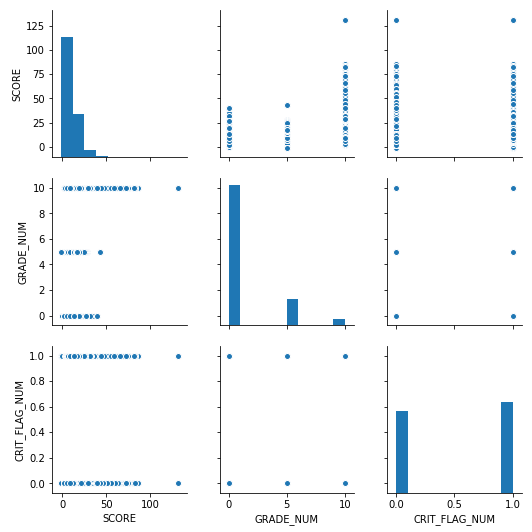

In [11]:
sns.pairplot(df_stats1[['SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


(array([1.35244e+05, 4.89850e+04, 8.37500e+03, 1.96500e+03, 5.59000e+02,
        9.20000e+01, 3.20000e+01, 0.00000e+00, 0.00000e+00, 7.00000e+00]),
 array([ -1. ,  12.2,  25.4,  38.6,  51.8,  65. ,  78.2,  91.4, 104.6,
        117.8, 131. ]),
 <a list of 10 Patch objects>)

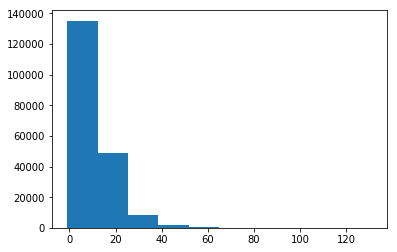

In [12]:
score = df_stats['SCORE']
plt.hist(score)

(array([157829.,      0.,      0.,      0.,      0.,  29993.,      0.,
             0.,      0.,   7437.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

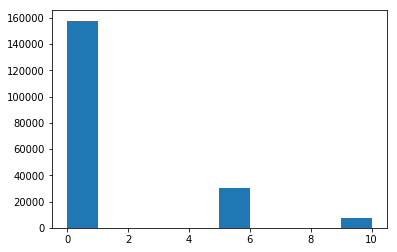

In [13]:
grade_num = df_stats1['GRADE_NUM']
plt.hist(grade_num)

(array([ 92660.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 102599.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

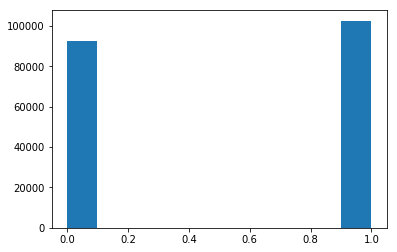

In [14]:
crit_flag_num = df_stats1['CRIT_FLAG_NUM']
plt.hist(crit_flag_num)

# Add Yelp Data, Data Cleaning

df_yelp = Read in Yelp data as a DataFrame, and add a 'RATINGS' column that just has the rating number

In [15]:
yelp = '/Users/allandong/ds/metis/metisgh/Metis_Work/02-project-two-Luther/yelp.csv'

df_yelp= pd.read_csv(yelp)

yelp_cols = ['URL', 'YELP_RATINGS']
df_yelp.columns = yelp_cols

df_yelp = df_yelp[df_yelp['YELP_RATINGS'] != 'yelp_ratings']

def get_num(row):
    return float(row['YELP_RATINGS'].split()[0])

df_yelp['RATINGS'] = df_yelp.apply(get_num, axis=1)


In [16]:
def grader(row):
    grade = row['GRADE']
    if grade=='A':
        return 0
    elif grade=='B':
        return 5
    elif grade=='C':
        return 10

def criticalflag(row):
    flag = row['CRITICAL_FLAG']
    if flag == 'Critical':
        return 1
    elif flag == 'Not Critical':
        return 0

df_short = Remove extraneous columns from df_clean before concat

In [17]:
df_short = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'PHONE',
                          'INSPECTION_DATE',
                          'ACTION',
                          'VIOLATION_DESC',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                         ], 1)


df_ex_pre = Concating df_short and df_yelp and with NaN's dropped

In [18]:
df_ex_pre= pd.merge(df_short, df_yelp, how='left',on='URL')

df_ex_pre = df_ex_pre.drop_duplicates().dropna(axis=0, how='any')

Remove all grades with that are not A, B or C

In [19]:
df_ex = df_ex_pre[df_ex_pre['GRADE'] != 'Z']
df_ex = df_ex[df_ex['GRADE'] != 'P']
df_ex = df_ex[df_ex['GRADE'] != 'Not Yet Graded']



dfex_cols = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex = df_ex[dfex_cols]

In [20]:
dfex_cols_viol = ['RATINGS', 'SCORE', 'CRITICAL_FLAG', 'GRADE', 'VIOLATION_CODE']
dfex_viol_pre = df_ex[dfex_cols_viol]


df_ex_prex = df_ex.drop(['ZIPCODE', 'CUISINE_DESC', 'URL', 'YELP_RATINGS'],
           axis = 1)



In [21]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=dfex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=dfex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=dfex, return_type="dataframe").drop('Intercept', 1)



In [22]:
dfex_patsy = pd.concat([dfex, grade_num_patsy, critical_flag_patsy, violation_code_patsy], 
                      axis = 1, join_axes = [dfex.index])




dfex = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG', 'VIOLATION_CODE'], 1)
dfex_viol = dfex_viol_pre.drop(['GRADE', 'CRITICAL_FLAG'], 1)


In [23]:


#cuisine_desc = pd.get_dummies(df_exx['CUISINE_DESC'])
#critical_flag = pd.get_dummies(df_exx['CRITICAL_FLAG'])
#grade_num = pd.get_dummies(df_exx['GRADE'])




In [24]:
df_exx = df_ex_prex


critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_exx, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_exx, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_exx, return_type="dataframe").drop('Intercept', 1)


#df_exx = pd.concat([df_exx, grade_num, critical_flag], axis = 1, join_axes = [df_exx.index])
df_exx = pd.concat([df_exx, 
                    grade_num_patsy, 
                    critical_flag_patsy, 
                    violation_code_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_exx = df_exx.drop(['VIOLATION_CODE', 'CRITICAL_FLAG', 'GRADE'],
           axis = 1)




In [25]:
dfex_patsy.head()

,RATINGS,SCORE,CRITICAL_FLAG,GRADE,VIOLATION_CODE,GRADE[T.B],GRADE[T.C],CRITICAL_FLAG[T.Not Critical],VIOLATION_CODE[T.02B],VIOLATION_CODE[T.02C],...,VIOLATION_CODE[T.10A],VIOLATION_CODE[T.10B],VIOLATION_CODE[T.10C],VIOLATION_CODE[T.10D],VIOLATION_CODE[T.10E],VIOLATION_CODE[T.10F],VIOLATION_CODE[T.10G],VIOLATION_CODE[T.10H],VIOLATION_CODE[T.10I],VIOLATION_CODE[T.10J]
0,2.5,27.0,Critical,B,02B,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3.5,9.0,Critical,A,02B,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,4.0,12.0,Critical,A,06D,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,4.0,7.0,Not Critical,A,10F,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
106,4.0,7.0,Critical,A,06F,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check each column for non numeric values

Examine data and preliminary analysis of R2

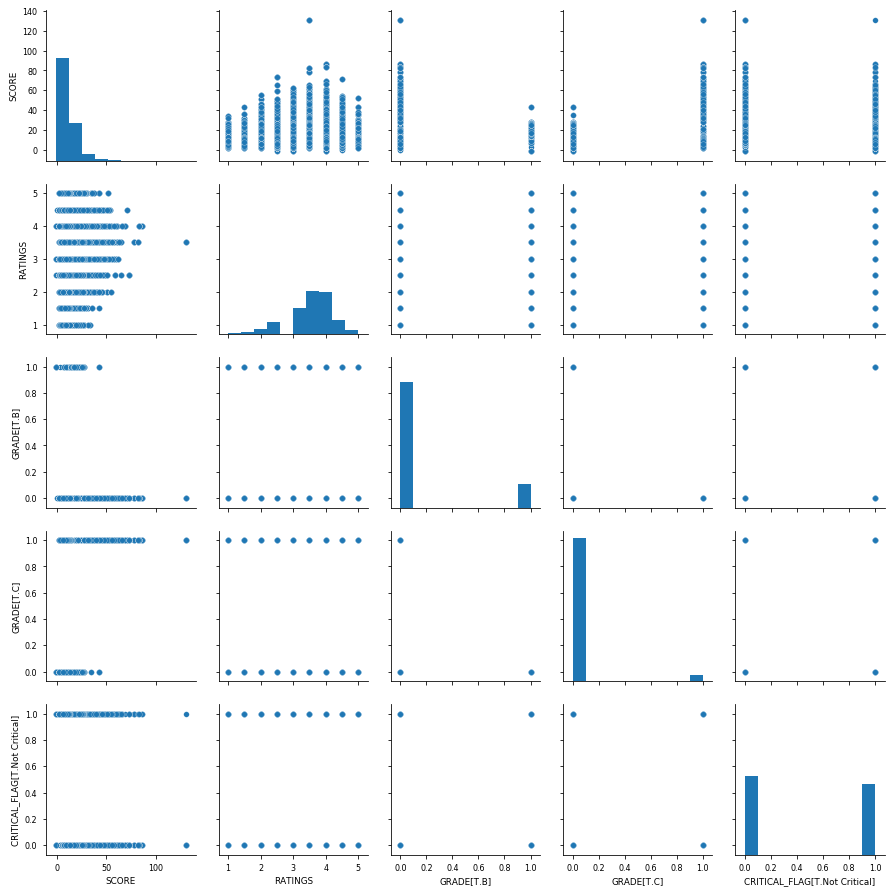

In [26]:
sns.set_context("paper")
sns.pairplot(dfex_patsy[['SCORE','RATINGS', 'GRADE[T.B]', 'GRADE[T.C]',
       'CRITICAL_FLAG[T.Not Critical]']], kind="scatter", diag_kind="hist")


In [27]:
dfex_patsy.rename(columns={'CRITICAL_FLAG[T.Not Critical]':'CRITICAL_FLAG[T.NotCritical]'}, inplace=True)

In [28]:
dfex.corr()

,RATINGS,SCORE
RATINGS,1.000000,-0.028029
SCORE,-0.028029,1.000000


In [29]:
dfex_patsy

,RATINGS,SCORE,CRITICAL_FLAG,GRADE,VIOLATION_CODE,GRADE[T.B],GRADE[T.C],CRITICAL_FLAG[T.NotCritical],VIOLATION_CODE[T.02B],VIOLATION_CODE[T.02C],...,VIOLATION_CODE[T.10A],VIOLATION_CODE[T.10B],VIOLATION_CODE[T.10C],VIOLATION_CODE[T.10D],VIOLATION_CODE[T.10E],VIOLATION_CODE[T.10F],VIOLATION_CODE[T.10G],VIOLATION_CODE[T.10H],VIOLATION_CODE[T.10I],VIOLATION_CODE[T.10J]
0,2.5,27.0,Critical,B,02B,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3.5,9.0,Critical,A,02B,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,4.0,12.0,Critical,A,06D,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,4.0,7.0,Not Critical,A,10F,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
106,4.0,7.0,Critical,A,06F,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,4.0,12.0,Critical,A,04A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,3.0,13.0,Not Critical,A,09C,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,4.0,11.0,Critical,A,06C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,3.0,13.0,Critical,A,02G,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,4.0,18.0,Critical,B,06A,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
y, X = patsy.dmatrices('RATINGS ~ SCORE + RATINGS + GRADE[T.B] + GRADE[T.C] + CRITICAL_FLAG[T.Not_Critical]', 
                       data=dfex_patsy, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()


#lml = smf.ols('Y ')

PatsyError: Error evaluating factor: NameError: name 'T' is not defined
    RATINGS ~ SCORE + RATINGS + GRADE[T.B] + GRADE[T.C] + CRITICAL_FLAG[T.Not_Critical]
                                             ^^^^^^^^^^

Check R2 with LinearRegression


Legend:

dfex : [y = 'RATINGS', x = 'SCORE', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex1 : [y = 'SCORE', x ='RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM']

dfex2 : [y = 'SCORE', x ='RATINGS', 'CRIT_FLAG_NUM']

dfex1_viol : [y = 'SCORE', x = 'RATINGS', 'GRADE_NUM', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

dfex2_viol : [y = 'SCORE', x = 'RATINGS', 'CRIT_FLAG_NUM', VIOLATION_CODE-dummies]

In [31]:

dfex1_cols = ['SCORE', 'RATINGS', 'GRADE[T.B]', 'GRADE[T.C]', 'CRITICAL_FLAG[T.Not Critical]']
dfex1= dfex_patsy[dfex1_cols]


dfex1_viol = dfex_patsy

KeyError: "['CRITICAL_FLAG[T.Not Critical]'] not in index"

In [32]:
dfex2 = dfex1.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
dfex2_viol = dfex1_viol.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)


NameError: name 'dfex1' is not defined

In [ ]:
lr = LinearRegression()
X = dfex1.iloc[:, 1:]
y = dfex1.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
lr = LinearRegression(fit_intercept = True)





X = dfex2.iloc[:, 1:]
y = dfex2.SCORE
lr.fit(X,y)
lr.score(X,y)
#print('X: ', list(X))
#print(dfex2.columns)

In [ ]:
dfex2.columns

In [ ]:

X = dfex1_viol.iloc[:, 1:]
y = dfex1_viol.iloc[:, 0]

lr.fit(X, y)
lr.score(X,y)

In [ ]:
X = dfex2_viol.iloc[:, 1:]
y = dfex2_viol.iloc[:, 0]

lr.fit(X,y)
lr.score(X,y)

In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str


In [ ]:
dfex_patsy.columns

In [ ]:
dfex_patsy1 = dfex_patsy.drop(['GRADE', 'VIOLATION_CODE', 'CRITICAL_FLAG'],1 )

y_dfex2 = dfex_patsy1.SCORE
X_dfex2 = dfex_patsy1.drop(['SCORE'], 1)

model_dfex2 = sm.OLS(y_dfex2, X_dfex2)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
critical_flag_patsy = patsy.dmatrix('CRITICAL_FLAG', data=df_ex, return_type='dataframe').drop('Intercept', 1)
grade_num_patsy = patsy.dmatrix('GRADE', data=df_ex, return_type='dataframe').drop('Intercept', 1)
violation_code_patsy = patsy.dmatrix('VIOLATION_CODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)
zipcode_patsy = patsy.dmatrix('ZIPCODE', data=df_ex, return_type="dataframe").drop('Intercept', 1)

df_dummy_cgvz = pd.concat([df_ex, 
#                      grade_num_patsy, 
#                      critical_flag_patsy, 
#                      violation_code_patsy,
                      zipcode_patsy
                   ], axis = 1, join_axes = [df_exx.index])

df_dummy_cgvz = df_dummy_cgvz.drop(['VIOLATION_CODE', 
                                    'CRITICAL_FLAG', 
                                    'GRADE', 
                                    'ZIPCODE', 
                                    'CUISINE_DESC',
                                    'URL',
                                    'YELP_RATINGS'
                                   ],axis = 1)

df_dummy_cgvz.columns


In [ ]:
master = dfex2
#df_dummy_cgvz
y = master.SCORE
X= master.drop(['SCORE'], 1)

print(X.columns)

model_dfex2 = sm.OLS(y, X)
fit_dfex2 =model_dfex2.fit()
fit_dfex2.summary()


In [ ]:
df_ex.columns

In [ ]:
lr = LinearRegression()

df_exx_lr= df_exx.drop(['GRADE[T.B]', 'GRADE[T.C]'], 1)
X = df_exx_lr.drop(['RATINGS'], 1)
y = df_exx_lr.RATINGS

lr.fit(X, y)
lr.score(X, y)

In [ ]:
df_exx_lr.columns

In [ ]:
reg = LinearRegression()
X = df_exx.iloc[:, 1:]
y = df_exx.iloc[:, 0]
scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

In [ ]:
sns.pairplot(dfex_patsy[['SCORE', 'RATINGS','GRADE[T.B]','GRADE[T.C]','CRITICAL_FLAG[T.Not Critical]']], 
                       kind="scatter",
                       diag_kind="hist"
                       )


In [ ]:
dfex2_viol_cols = ''
for i in dfex2_viol.columns:
    dfex2_viol_cols += i + "+"
dfex2_viol_patsy_str = 'SCORE ~ '+ dfex2_viol_cols[6:-1]
dfex2_viol_patsy_str

In [ ]:
'''y, X = patsy.dmatrices(dfex2_viol_patsy_str,
                       data=dfex2_viol, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()
'''

In [ ]:
'''df_exx_cols = ''
for i in df_exx.columns:
    df_exx_cols += i + " + "
df_exx_cols = "SCORE ~ " + df_exx_cols[8:-3] 
df_exx_cols'''

In [ ]:
'''y_df_exx, X_df_exxx = patsy.dmatrices(df_exx_cols, data=df_exx, return_type="dataframe")
model_df_exx = sm.OLS(y_df_exx, X_df_exx)
fit_df_exx = model_df_exx.fit()
fit_df_exx.summary()'''

# Violation Code

In [ ]:
df_viol = df_clean.drop(['CAMIS', 
                          'DBA',
                          'BORO', 
                          'BUILDING', 
                          'STREET', 
                          'ZIPCODE',
                          'PHONE',
                          'CUISINE_DESC',
                          'INSPECTION_DATE',
                          'ACTION',
                          'SCORE',
                          'GRADE',
                          'GRADE_DATE',
                          'RECORD_DATE',
                          'INSPECTION_TYPE',
                          'ADDRESS',
                          'URL'
                         ], 1)
df_viol = df_viol.drop_duplicates(subset='VIOLATION_CODE')
df_viol =df_viol.sort_values(['VIOLATION_CODE'])
df_viol.head(60)

# Data Exploration 2/2

In [ ]:
df_ex.head()

In [ ]:
sns.set_context("talk")
score = dfex_viol['SCORE']
sns.distplot(score, kde = False)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1)

In [ ]:
sns.set_context("poster")

data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])

yaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']
xaxes = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['SCORE']
sns.boxplot(x=xaxes, y=yaxes, data=data1, ax = (16, 30))

In [ ]:

score = dfex_viol['SCORE']
sns.distplot(score)

In [ ]:
data1=dfex_viol.sort_values(['VIOLATION_CODE'][-1])
y = dfex_viol.sort_values(['VIOLATION_CODE'][-1])['VIOLATION_CODE']



# Plot

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS

sns.regplot(x, y)

In [ ]:
sns.regplot(y, x)

In [ ]:
x =df_ex.SCORE
y = df_ex.RATINGS.apply(,1)

sns.regplot(x, y)